# Table des Matières
1. [Import package](#import)
2. [Prétraitement des données](#traitement)
3. [Premier Cycle](#cycle1)
4. [Deuxième Cycle (Feature Engineering)](#cycle2)
5. [Troisième Cycle (Hyperparamètres - Optuna)](#cycle3)
    * [Regression Logistique](#cycle3_1)
    * [Arbre de décision](#cycle3_2)
    * [Courbe ROC](#cycle3_3)
6. [Prédiction](#pred)

---


## Import des packages et des données <a class="anchor" id="import"></a>

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import optuna 
import itertools


# Charger le jeu de données
data = pd.read_csv("data/revenus.csv")

## Prétraitement des données <a class="anchor" id="traitement"></a>

In [24]:
# Première itération
# Remplacer les '?' par NaN pour un traitement plus facile des valeurs manquantes
data.replace('?', pd.NA, inplace=True)

# Étape 1: Encodage des variables catégorielles
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'gender', 'native-country', 'income']
label_encoders = {}

# Encoder chaque colonne catégorielle
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col].astype(str))

# Vérification et suppression de la colonne 'fnlwgt' si elle existe
if 'fnlwgt' in data.columns:
    data.drop(columns=['fnlwgt'], inplace=True)

# Exclure 'capital-gain' et 'capital-loss' des variables pour la détection d'anomalies
X_for_outlier_detection = data.drop(columns=['capital-gain', 'capital-loss', 'income'])

# Isolation Forest pour détecter les valeurs aberrantes
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X_for_outlier_detection)

# Ajouter une colonne pour indiquer les valeurs aberrantes
data['outlier'] = outliers

# Afficher les premières lignes des données après avoir marqué les valeurs aberrantes
print("\nDonnées après Isolation Forest (1 = non-aberrant, -1 = aberrant) :")
print(data[['age', 'workclass', 'capital-gain', 'capital-loss', 'outlier']].head())

# Garder uniquement les points qui ne sont pas des anomalies
data_cleaned = data[data['outlier'] == 1].drop(columns=['outlier'])

# Afficher les premières lignes des données après suppression des valeurs aberrantes
print("\nDonnées après suppression des valeurs aberrantes :")
print(data_cleaned[['age', 'workclass', 'capital-gain', 'capital-loss']].head())

# Étape 2: Normalisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


Données après Isolation Forest (1 = non-aberrant, -1 = aberrant) :
   age  workclass  capital-gain  capital-loss  outlier
0   25          4             0             0        1
1   38          4             0             0        1
2   28          2             0             0        1
3   44          4          7688             0        1
4   18          0             0             0        1

Données après suppression des valeurs aberrantes :
   age  workclass  capital-gain  capital-loss
0   25          4             0             0
1   38          4             0             0
2   28          2             0             0
3   44          4          7688             0
4   18          0             0             0


#### KNN et Matrice de Corrélation

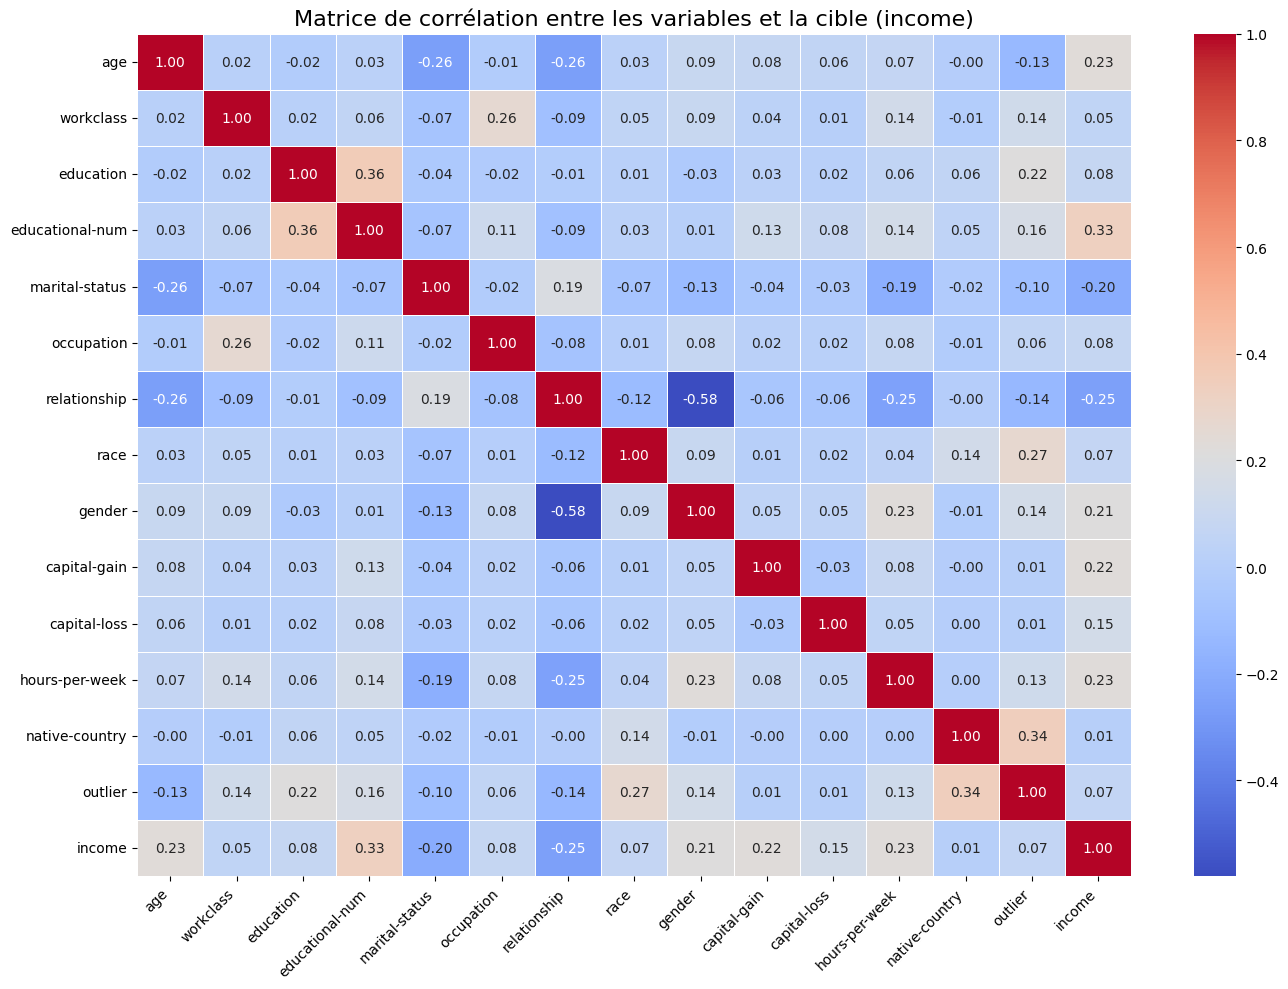

In [25]:
# Étape 3: Imputation des valeurs manquantes par KNN
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(scaled_data)

# Convertir les données imputées en DataFrame
imputed_data = pd.DataFrame(imputed_data, columns=data.columns)



# Récupérer la variable cible (income) sous sa forme originale encodée en 0 et 1
y = data['income']  # Réutiliser la variable d'origine (non normalisée)

# Diviser les données en variables explicatives et cible
X = imputed_data.drop(columns=['income'])

# ### Présentation des corrélations ###
# Ajouter la colonne income au DataFrame des variables pour calculer les corrélations
correlation_matrix = pd.concat([X, y], axis=1).corr()

# Visualisation des corrélations
plt.figure(figsize=(14, 10))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 10})
plt.title("Matrice de corrélation entre les variables et la cible (income)", fontsize=16)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)
plt.tight_layout()  
plt.show()

## Premier Cycle <a class="anchor" id="cycle1"></a>

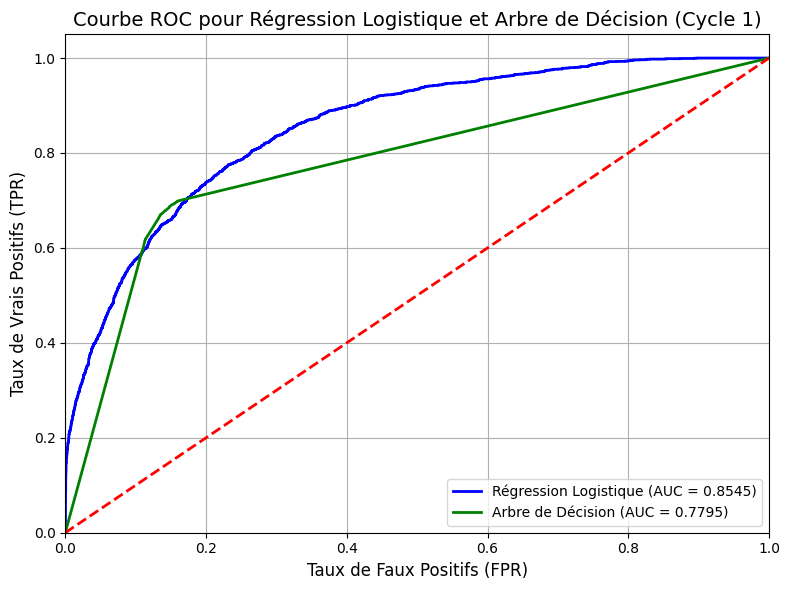


Régression Logistique (Cycle 1) :
Accuracy: 0.8274
F1-Score: 0.5497
AUC: 0.8545
gAUC: 0.8280

Arbre de Décision (Cycle 1) :
Accuracy: 0.8232
F1-Score: 0.6217
AUC: 0.7795
gAUC: 0.7649


In [26]:
# Fonction pour calculer le gAUC
def calculate_gauc(y_true, y_pred_proba, group_column):
    unique_groups = group_column.unique()
    group_auc_scores = []
    group_sizes = []
    
    for group in unique_groups:
        group_mask = (group_column == group)
        if len(np.unique(y_true[group_mask])) > 1:  # Vérifie qu'il y a au moins deux classes dans le groupe
            auc_score = roc_auc_score(y_true[group_mask], y_pred_proba[group_mask])
            group_auc_scores.append(auc_score)
            group_sizes.append(group_mask.sum())
    
    # Calcul du gAUC comme moyenne pondérée des AUC des groupes
    gauc = np.average(group_auc_scores, weights=group_sizes)
    return gauc

# Étape 4: Diviser les données en ensemble d'entraînement et de test
X_train_cycle1, X_test_cycle1, y_train_cycle1, y_test_cycle1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement des modèles - Cycle 1
# Modèle de régression logistique
log_reg_cycle1 = LogisticRegression(max_iter=1000)
log_reg_cycle1.fit(X_train_cycle1, y_train_cycle1)

# Modèle d'arbre de décision
decision_tree_cycle1 = DecisionTreeClassifier(random_state=42)
decision_tree_cycle1.fit(X_train_cycle1, y_train_cycle1)

# Prédictions - Cycle 1
y_pred_prob_log_reg_cycle1 = log_reg_cycle1.predict_proba(X_test_cycle1)[:, 1]
y_pred_prob_tree_cycle1 = decision_tree_cycle1.predict_proba(X_test_cycle1)[:, 1]

# Calcul des courbes ROC - Cycle 1
fpr_log_reg_cycle1, tpr_log_reg_cycle1, _ = roc_curve(y_test_cycle1, y_pred_prob_log_reg_cycle1)
fpr_tree_cycle1, tpr_tree_cycle1, _ = roc_curve(y_test_cycle1, y_pred_prob_tree_cycle1)

# Calcul des AUC - Cycle 1
roc_auc_log_reg_cycle1 = auc(fpr_log_reg_cycle1, tpr_log_reg_cycle1)
roc_auc_tree_cycle1 = auc(fpr_tree_cycle1, tpr_tree_cycle1)

group_column_cycle1 = X_test_cycle1['gender'] 

# Affichage de la courbe ROC - Cycle 1
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg_cycle1, tpr_log_reg_cycle1, color='blue', lw=2, label=f'Régression Logistique (AUC = {roc_auc_log_reg_cycle1:.4f})')
plt.plot(fpr_tree_cycle1, tpr_tree_cycle1, color='green', lw=2, label=f'Arbre de Décision (AUC = {roc_auc_tree_cycle1:.4f})')

# Ajout de la diagonale
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)

# Paramètres de la courbe
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbe ROC pour Régression Logistique et Arbre de Décision (Cycle 1)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Affichage des résultats - Cycle 1
log_reg_metrics_cycle1 = {
    "Accuracy": accuracy_score(y_test_cycle1, log_reg_cycle1.predict(X_test_cycle1)),
    "F1-Score": f1_score(y_test_cycle1, log_reg_cycle1.predict(X_test_cycle1)),
    "AUC": roc_auc_log_reg_cycle1,
    "gAUC": calculate_gauc(y_test_cycle1, y_pred_prob_log_reg_cycle1, group_column_cycle1)
}

tree_metrics_cycle1 = {
    "Accuracy": accuracy_score(y_test_cycle1, decision_tree_cycle1.predict(X_test_cycle1)),
    "F1-Score": f1_score(y_test_cycle1, decision_tree_cycle1.predict(X_test_cycle1)),
    "AUC": roc_auc_tree_cycle1,
    "gAUC": calculate_gauc(y_test_cycle1, y_pred_prob_tree_cycle1, group_column_cycle1)
}

print("\nRégression Logistique (Cycle 1) :")
for metric, value in log_reg_metrics_cycle1.items():
    print(f"{metric}: {value:.4f}")

print("\nArbre de Décision (Cycle 1) :")
for metric, value in tree_metrics_cycle1.items():
    print(f"{metric}: {value:.4f}")


## Deuxième Cycle (Feature Engineering) <a class="anchor" id="cycle2"></a>

/var/folders/rc/xhmcyg0x1d9b_n3m80ww6sxr0000gn/T/ipykernel_8279/3290048591.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interactions[f'{col1}_per_{col2}'] = data[col1] / (data[col2] + 1e-5)
/var/folders/rc/xhmcyg0x1d9b_n3m80ww6sxr0000gn/T/ipykernel_8279/3290048591.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interactions[f'{col2}_per_{col1}'] = data[col2] / (data[col1] + 1e-5)
/var/folders/rc/xhmcyg0x1d9b_n3m80ww6sxr0000gn/T/ipykernel_8279/3290048591.py:8: PerformanceWarning: DataFrame is highly fragmented.  This 


Régression Logistique (Cycle 2) :
Accuracy: 0.8584
F1-Score: 0.6627
AUC: 0.9098
gAUC: 0.9009

Arbre de Décision (Cycle 2) :
Accuracy: 0.8548
F1-Score: 0.6167
AUC: 0.8912
gAUC: 0.8798


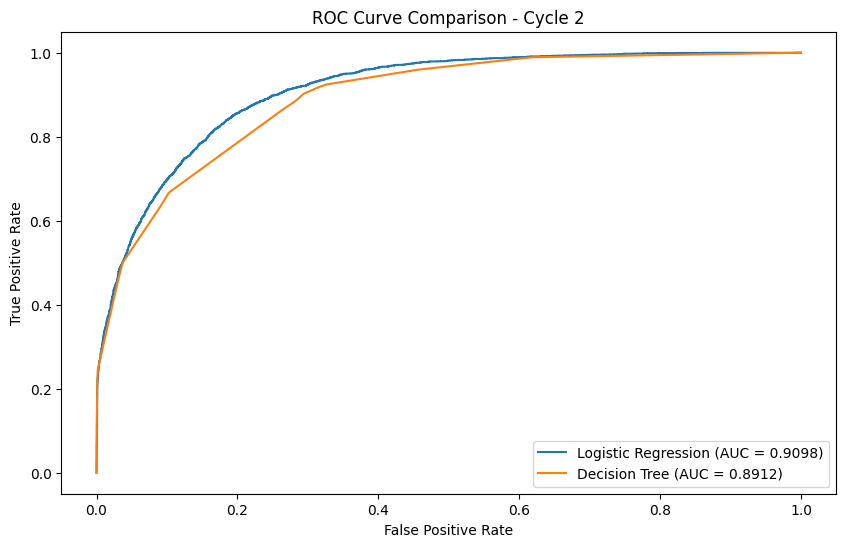

In [27]:
# Fonction pour générer toutes les interactions possibles entre les variables
def generate_interactions(data):
    columns = data.columns
    interactions = pd.DataFrame(index=data.index)  # Créer un DataFrame vide avec le même index que les données originales

    # Boucle sur toutes les paires de colonnes
    for col1, col2 in itertools.combinations(columns, 2):
        interactions[f'{col1}_x_{col2}'] = data[col1] * data[col2]
        interactions[f'{col1}_per_{col2}'] = data[col1] / (data[col2] + 1e-5)
        interactions[f'{col2}_per_{col1}'] = data[col2] / (data[col1] + 1e-5)
    
    return interactions

# Séparation des variables explicatives et de la cible
X_cycle2 = data.drop(columns=['income'])  # Suppression de la colonne cible
y_cycle2 = data['income']

# Feature engineering - Cycle 2
X_cycle2['log_capital_gain'] = np.log1p(X_cycle2['capital-gain'])
X_cycle2['sqrt_age'] = np.sqrt(X_cycle2['age'])

# Génération des interactions
X_interactions_cycle2 = generate_interactions(X_cycle2)

# Combinaison des interactions avec les features existantes
X_combined_cycle2 = pd.concat([X_cycle2, X_interactions_cycle2], axis=1)

# Ajout des features indicatives
X_combined_cycle2['has_capital_gain'] = (X_combined_cycle2['capital-gain'] > 0).astype(int)
X_combined_cycle2['is_senior'] = (X_combined_cycle2['age'] > 50).astype(int)

# Split des données - Cycle 2
X_train_cycle2, X_test_cycle2, y_train_cycle2, y_test_cycle2 = train_test_split(X_combined_cycle2, y_cycle2, test_size=0.3, random_state=42)

# Alignement pour le gAUC
group_column_cycle2 = X_test_cycle2['gender'].reset_index(drop=True)
y_test_aligned_cycle2 = y_test_cycle2.reset_index(drop=True)

# Normalisation
scaler_cycle2 = StandardScaler()
X_train_scaled_cycle2 = scaler_cycle2.fit_transform(X_train_cycle2)
X_test_scaled_cycle2 = scaler_cycle2.transform(X_test_cycle2)

# Entraînement des modèles
log_reg_cycle2 = LogisticRegression(solver='liblinear', penalty='l2', C=1.0)
log_reg_cycle2.fit(X_train_scaled_cycle2, y_train_cycle2)

tree_clf_cycle2 = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
tree_clf_cycle2.fit(X_train_scaled_cycle2, y_train_cycle2)

# Prédictions
y_pred_log_reg_cycle2 = log_reg_cycle2.predict(X_test_scaled_cycle2)
y_pred_prob_log_reg_cycle2 = log_reg_cycle2.predict_proba(X_test_scaled_cycle2)[:, 1]

y_pred_tree_cycle2 = tree_clf_cycle2.predict(X_test_scaled_cycle2)
y_pred_prob_tree_cycle2 = tree_clf_cycle2.predict_proba(X_test_scaled_cycle2)[:, 1]

# Calcul des métriques
log_reg_metrics_cycle2 = {
    "Accuracy": accuracy_score(y_test_aligned_cycle2, y_pred_log_reg_cycle2),
    "F1-Score": f1_score(y_test_aligned_cycle2, y_pred_log_reg_cycle2),
    "AUC": roc_auc_score(y_test_aligned_cycle2, y_pred_prob_log_reg_cycle2),
    "gAUC": calculate_gauc(y_test_aligned_cycle2, y_pred_prob_log_reg_cycle2, group_column_cycle2)
}

tree_metrics_cycle2 = {
    "Accuracy": accuracy_score(y_test_aligned_cycle2, y_pred_tree_cycle2),
    "F1-Score": f1_score(y_test_aligned_cycle2, y_pred_tree_cycle2),
    "AUC": roc_auc_score(y_test_aligned_cycle2, y_pred_prob_tree_cycle2),
    "gAUC": calculate_gauc(y_test_aligned_cycle2, y_pred_prob_tree_cycle2, group_column_cycle2)
}

# Affichage des métriques
print("\nRégression Logistique (Cycle 2) :")
for metric, value in log_reg_metrics_cycle2.items():
    print(f"{metric}: {value:.4f}")

print("\nArbre de Décision (Cycle 2) :")
for metric, value in tree_metrics_cycle2.items():
    print(f"{metric}: {value:.4f}")

# Courbes ROC - Cycle 2
fpr_log_reg_cycle2, tpr_log_reg_cycle2, _ = roc_curve(y_test_aligned_cycle2, y_pred_prob_log_reg_cycle2)
fpr_tree_cycle2, tpr_tree_cycle2, _ = roc_curve(y_test_aligned_cycle2, y_pred_prob_tree_cycle2)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg_cycle2, tpr_log_reg_cycle2, label='Logistic Regression (AUC = {:.4f})'.format(log_reg_metrics_cycle2['AUC']))
plt.plot(fpr_tree_cycle2, tpr_tree_cycle2, label='Decision Tree (AUC = {:.4f})'.format(tree_metrics_cycle2['AUC']))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Cycle 2')
plt.legend()
plt.show()


## Troisième Cycle (Hyperparamètres - Optuna) <a class="anchor" id="cycle3"></a>

###  Regression Logistique <a class="anchor" id="cycle3_1"></a>

In [7]:
from sklearn.decomposition import PCA
import optuna

# 1. Appliquer PCA pour réduire la dimensionnalité
pca_cycle3 = PCA(n_components=0.9999)  # 99.99% de la variance expliquée

# Ajuster la PCA sur les données d'entraînement et transformer
X_train_pca_cycle3 = pca_cycle3.fit_transform(X_train_scaled_cycle2)
X_test_pca_cycle3 = pca_cycle3.transform(X_test_scaled_cycle2)

print(f"Nombre de composantes après PCA : {X_train_pca_cycle3.shape[1]}")

# 2. Optimisation de la régression logistique avec Optuna

def objective_log_reg_cycle3(trial):
    # Hyperparamètres à optimiser avec Optuna
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.001, 100, log=True)
    
    # Création du modèle
    log_reg_cycle3 = LogisticRegression(penalty=penalty, C=C, solver='saga', max_iter=1000)
    log_reg_cycle3.fit(X_train_pca_cycle3, y_train_cycle2)
    
    # Prédictions et AUC sur l'ensemble de test
    y_pred_proba_cycle3 = log_reg_cycle3.predict_proba(X_test_pca_cycle3)[:, 1]
    auc_score = roc_auc_score(y_test_cycle2, y_pred_proba_cycle3)
    
    return auc_score

# Étude avec Optuna
study_log_reg_cycle3 = optuna.create_study(direction='maximize')
study_log_reg_cycle3.optimize(objective_log_reg_cycle3, n_trials=15)

# Meilleurs hyperparamètres pour la régression logistique
best_params_log_reg_cycle3 = study_log_reg_cycle3.best_params
print(f"Meilleurs hyperparamètres pour la Régression Logistique : {best_params_log_reg_cycle3}")

# Entraînement du modèle optimisé
best_log_reg_cycle3 = LogisticRegression(**best_params_log_reg_cycle3, solver='saga', max_iter=1000)
best_log_reg_cycle3.fit(X_train_pca_cycle3, y_train_cycle2)

# Prédictions et calcul des métriques pour le modèle optimisé
y_pred_log_reg_cycle3 = best_log_reg_cycle3.predict(X_test_pca_cycle3)
y_pred_prob_log_reg_cycle3 = best_log_reg_cycle3.predict_proba(X_test_pca_cycle3)[:, 1]

auc_log_reg_cycle3 = roc_auc_score(y_test_cycle2, y_pred_prob_log_reg_cycle3)
f1_log_reg_cycle3 = f1_score(y_test_cycle2, y_pred_log_reg_cycle3)
accuracy_log_reg_cycle3 = accuracy_score(y_test_cycle2, y_pred_log_reg_cycle3)

# Calcul du gAUC
group_column_cycle3 = X_test_cycle2['gender'].reset_index(drop=True)
y_test_aligned_cycle3 = y_test_cycle2.reset_index(drop=True)
gauc_log_reg_cycle3 = calculate_gauc(y_test_aligned_cycle3, y_pred_prob_log_reg_cycle3, group_column_cycle3)

# Résultats pour la régression logistique optimisée - Cycle 3
print("\nRégression Logistique Optimisée (Cycle 3) :")
print(f"Accuracy: {accuracy_log_reg_cycle3:.4f}")
print(f"F1-Score: {f1_log_reg_cycle3:.4f}")
print(f"AUC: {auc_log_reg_cycle3:.4f}")
print(f"gAUC: {gauc_log_reg_cycle3:.4f}")


[I 2024-11-12 18:03:29,793] A new study created in memory with name: no-name-4c8e353c-061a-4ee9-838f-4472f9819ec9


Nombre de composantes après PCA : 239


[I 2024-11-12 18:03:33,294] Trial 0 finished with value: 0.8879563426058247 and parameters: {'penalty': 'l1', 'C': 0.0014896959258774095}. Best is trial 0 with value: 0.8879563426058247.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-11-12 18:04:37,481] Trial 1 finished with value: 0.9096723287639854 and parameters: {'penalty': 'l1', 'C': 0.10833733007593155}. Best is trial 1 with value: 0.9096723287639854.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-11-12 18:05:16,146] Trial 2 finished with value: 0.9102368074850469 and parameters: {'penalty': 'l2', 'C': 55.02561279927839}. Best is trial 2 with value: 0.9102368074850469.
/Library/Framew

Meilleurs hyperparamètres pour la Régression Logistique : {'penalty': 'l1', 'C': 0.6042618236140866}

Régression Logistique Optimisée (Cycle 3) :
Accuracy: 0.8588
F1-Score: 0.6629
AUC: 0.9103
gAUC: 0.9014


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


###  Arbre de décision <a class="anchor" id="cycle3_2"></a>

In [8]:
# 4. Optimisation de l'arbre de décision avec Optuna - Cycle 3

def objective_tree_cycle3(trial):
    # Hyperparamètres à optimiser
    max_depth = trial.suggest_int('max_depth', 3, 20)  
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20) 
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])  
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])  
    
    # Création du modèle d'arbre de décision
    tree_clf_cycle3 = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        splitter=splitter,
        random_state=42
    )
    
    # Entraînement
    tree_clf_cycle3.fit(X_train_pca_cycle3, y_train_cycle2)
    
    # Prédictions et calcul de l'AUC
    y_pred_proba_cycle3 = tree_clf_cycle3.predict_proba(X_test_pca_cycle3)[:, 1]
    auc_score = roc_auc_score(y_test_cycle2, y_pred_proba_cycle3)
    
    return auc_score

In [9]:
# Étudier et optimiser l'arbre de décision avec Optuna - Cycle 3
study_tree_cycle3 = optuna.create_study(direction='maximize')
study_tree_cycle3.optimize(objective_tree_cycle3, n_trials=30)  # Étude avec 30 essais pour optimiser

# Meilleur ensemble d'hyperparamètres - Cycle 3
best_params_tree_cycle3 = study_tree_cycle3.best_params
print(f"Meilleurs hyperparamètres pour l'Arbre de Décision - Cycle 3 : {best_params_tree_cycle3}")

# Entraînement du meilleur modèle - Cycle 3
best_tree_clf_cycle3 = DecisionTreeClassifier(**best_params_tree_cycle3, random_state=42)
best_tree_clf_cycle3.fit(X_train_pca_cycle3, y_train_cycle2)

# Prédictions et évaluation - Cycle 3
y_pred_tree_cycle3 = best_tree_clf_cycle3.predict(X_test_pca_cycle3)
y_pred_prob_tree_cycle3 = best_tree_clf_cycle3.predict_proba(X_test_pca_cycle3)[:, 1]

# Calcul des métriques - Cycle 3
auc_tree_cycle3 = roc_auc_score(y_test_cycle2, y_pred_prob_tree_cycle3)
f1_tree_cycle3 = f1_score(y_test_cycle2, y_pred_tree_cycle3)
accuracy_tree_cycle3 = accuracy_score(y_test_cycle2, y_pred_tree_cycle3)

# Calcul du gAUC pour l'arbre de décision - Cycle 3
gauc_tree_cycle3 = calculate_gauc(y_test_aligned_cycle3, y_pred_prob_tree_cycle3, group_column_cycle3)


[I 2024-11-12 18:18:23,890] A new study created in memory with name: no-name-9ce4b276-5091-4956-b637-cc757658396e
[I 2024-11-12 18:18:34,112] Trial 0 finished with value: 0.8158437337148325 and parameters: {'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 10, 'criterion': 'gini', 'splitter': 'best'}. Best is trial 0 with value: 0.8158437337148325.
[I 2024-11-12 18:18:34,457] Trial 1 finished with value: 0.8401050085821695 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'gini', 'splitter': 'random'}. Best is trial 1 with value: 0.8401050085821695.
[I 2024-11-12 18:18:34,613] Trial 2 finished with value: 0.8371933833218018 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'gini', 'splitter': 'random'}. Best is trial 1 with value: 0.8401050085821695.
[I 2024-11-12 18:18:43,168] Trial 3 finished with value: 0.8462531034550976 and parameters: {'max_depth': 12, 'min_samples_split': 16, 'min

Meilleurs hyperparamètres pour l'Arbre de Décision - Cycle 3 : {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7, 'criterion': 'entropy', 'splitter': 'best'}


###  Courbe ROC <a class="anchor" id="cycle3_3"></a>


Régression Logistique Optimisée (Cycle 3) :
Accuracy: 0.8588
F1-Score: 0.6629
AUC: 0.9103
gAUC: 0.9014

Arbre de Décision Optimisé (Cycle 3) :
Accuracy: 0.8431
F1-Score: 0.5705
AUC: 0.8863
gAUC: 0.8713


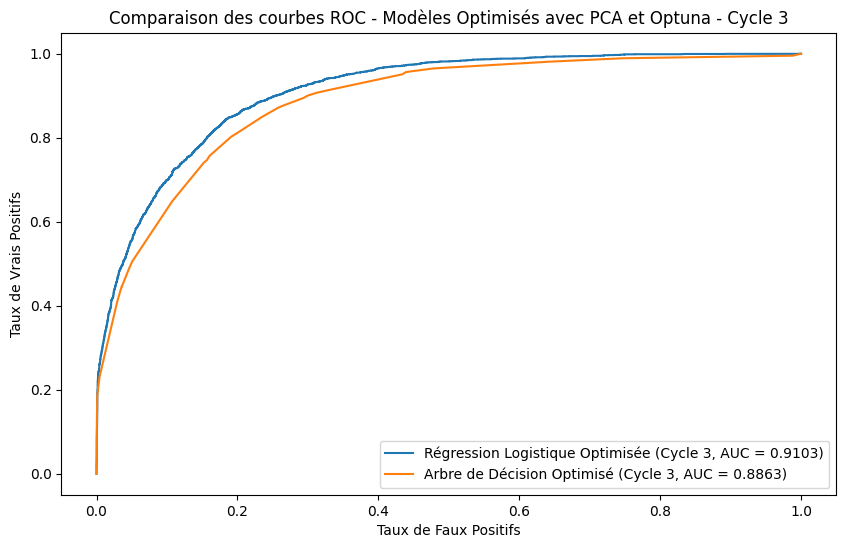

In [ ]:
# Calcul des métriques pour le modèle optimisé de régression logistique - Cycle 3
log_reg_optimized_metrics_cycle3 = {
    "Accuracy": accuracy_score(y_test_cycle2, best_log_reg_cycle3.predict(X_test_pca_cycle3)),
    "F1-Score": f1_score(y_test_cycle2, best_log_reg_cycle3.predict(X_test_pca_cycle3)),
    "AUC": roc_auc_score(y_test_cycle2, best_log_reg_cycle3.predict_proba(X_test_pca_cycle3)[:, 1]),
    "gAUC": calculate_gauc(y_test_aligned_cycle3, y_pred_prob_log_reg_cycle3, group_column_cycle3)
}

# Calcul des métriques pour le modèle optimisé d'arbre de décision - Cycle 3
tree_optimized_metrics_cycle3 = {
    "Accuracy": accuracy_score(y_test_cycle2, best_tree_clf_cycle3.predict(X_test_pca_cycle3)),
    "F1-Score": f1_score(y_test_cycle2, best_tree_clf_cycle3.predict(X_test_pca_cycle3)),
    "AUC": roc_auc_score(y_test_cycle2, best_tree_clf_cycle3.predict_proba(X_test_pca_cycle3)[:, 1]),
    "gAUC": calculate_gauc(y_test_aligned_cycle3, y_pred_prob_tree_cycle3, group_column_cycle3)
}

# Affichage des résultats pour les modèles optimisés - Cycle 3
print("\nRégression Logistique Optimisée (Cycle 3) :")
for metric, value in log_reg_optimized_metrics_cycle3.items():
    print(f"{metric}: {value:.4f}")

print("\nArbre de Décision Optimisé (Cycle 3) :")
for metric, value in tree_optimized_metrics_cycle3.items():
    print(f"{metric}: {value:.4f}")

# Comparaison des résultats avec courbe ROC - Cycle 3
fpr_log_reg_cycle3, tpr_log_reg_cycle3, _ = roc_curve(y_test_cycle2, best_log_reg_cycle3.predict_proba(X_test_pca_cycle3)[:, 1])
fpr_tree_cycle3, tpr_tree_cycle3, _ = roc_curve(y_test_cycle2, best_tree_clf_cycle3.predict_proba(X_test_pca_cycle3)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg_cycle3, tpr_log_reg_cycle3, label='Régression Logistique Optimisée (Cycle 3, AUC = {:.4f})'.format(log_reg_optimized_metrics_cycle3['AUC']))
plt.plot(fpr_tree_cycle3, tpr_tree_cycle3, label='Arbre de Décision Optimisé (Cycle 3, AUC = {:.4f})'.format(tree_optimized_metrics_cycle3['AUC']))
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Comparaison des courbes ROC - Modèles Optimisés avec PCA et Optuna - Cycle 3')
plt.legend()
plt.show()

##  Prédiction sur le nouveau jeu de données <a class="anchor" id="pred"></a>

In [38]:
# Charger le nouveau jeu de données
new_data = pd.read_csv('data/nouvelle_data.csv')

# Remplacer les '?' par NaN pour un traitement plus facile des valeurs manquantes
new_data.replace('?', pd.NA, inplace=True)

# Étape 1: Encodage des variables catégorielles
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'gender', 'native-country', 'income']
label_encoders = {}

# Encoder chaque colonne catégorielle
for col in categorical_columns:
    if col in new_data.columns:
        label_encoders[col] = LabelEncoder()
        new_data[col] = label_encoders[col].fit_transform(new_data[col].astype(str))

# Vérification et suppression de la colonne 'fnlwgt' si elle existe
if 'fnlwgt' in new_data.columns:
    new_data.drop(columns=['fnlwgt'], inplace=True)

# Exclure 'capital-gain' et 'capital-loss' des variables pour la détection d'anomalies
X_for_outlier_detection = new_data.drop(columns=['capital-gain', 'capital-loss', 'income'], errors='ignore')

# Isolation Forest pour détecter les valeurs aberrantes
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X_for_outlier_detection)

# Ajouter une colonne pour indiquer les valeurs aberrantes
new_data['outlier'] = outliers

# Afficher les premières lignes des données après avoir marqué les valeurs aberrantes
print("\nDonnées après Isolation Forest (1 = non-aberrant, -1 = aberrant) :")
print(new_data[['age', 'workclass', 'capital-gain', 'capital-loss', 'outlier']].head())

# Garder uniquement les points qui ne sont pas des anomalies
new_data_cleaned = new_data[new_data['outlier'] == 1].drop(columns=['outlier'])

# Afficher les premières lignes des données après suppression des valeurs aberrantes
print("\nDonnées après suppression des valeurs aberrantes :")
print(new_data_cleaned[['age', 'workclass', 'capital-gain', 'capital-loss']].head())

# Étape 2: Normalisation des données
scaler = StandardScaler()
scaled_new_data = scaler.fit_transform(new_data_cleaned)

# Étape 3: Imputation des valeurs manquantes par KNN
imputer = KNNImputer(n_neighbors=5)
imputed_new_data = imputer.fit_transform(scaled_new_data)

# Convertir les données imputées en DataFrame
imputed_new_data = pd.DataFrame(imputed_new_data, columns=new_data_cleaned.columns)

# Afficher les premières lignes des données finales après traitement
print("\nDonnées après imputation :")
print(imputed_new_data.head())

# Sauvegarder les données nettoyées pour les prédictions finales
imputed_new_data.to_csv('data/nouvelle_data_pretraitee.csv', index=False)
print("Les données prétraitées ont été sauvegardées dans 'nouvelle_data_pretraitee.csv'")


Données après Isolation Forest (1 = non-aberrant, -1 = aberrant) :
   age  workclass  capital-gain  capital-loss  outlier
0   41          3          4397             0        1
1   67          6             0             0        1
2   54          2             0             0        1
3   31          7          4378             0        1
4   32          5             0           618        1

Données après suppression des valeurs aberrantes :
   age  workclass  capital-gain  capital-loss
0   41          3          4397             0
1   67          6             0             0
2   54          2             0             0
3   31          7          4378             0
4   32          5             0           618

Données après imputation :
        age  workclass  education  educational-num  marital-status  \
0  0.196626  -0.418775   1.433938        -1.809279       -0.008105   
1  2.178652   0.758327   1.433938        -1.018031        1.502827   
2  1.187639  -0.811143   1.433938   

In [45]:
# Charger les nouvelles données
new_data = pd.read_csv('data/nouvelle_data_pretraitee.csv')

# Charger les données d'entraînement et scaler existants
revenus = pd.read_csv('data/revenus.csv')

# Redéfinir les encoders sur les données d'entraînement
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'gender', 'native-country', 'income']

label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    revenus[col] = label_encoders[col].fit_transform(revenus[col].astype(str))

# Appliquer les encoders au nouveau jeu de données
for col, encoder in label_encoders.items():
    if col in new_data.columns:
        all_categories = list(encoder.classes_) + list(new_data[col].astype(str).unique())
        encoder.classes_ = np.array(sorted(set(all_categories)))  # Mise à jour
        new_data[col] = encoder.transform(new_data[col].astype(str))

# Feature engineering sur les nouvelles données
new_data['log_capital_gain'] = np.log1p(new_data['capital-gain'])
new_data['sqrt_age'] = np.sqrt(new_data['age'])
new_data['has_capital_gain'] = (new_data['capital-gain'] > 0).astype(int)
new_data['is_senior'] = (new_data['age'] > 50).astype(int)

# Fonction pour générer toutes les interactions possibles entre les variables
def generate_interactions(data):
    columns = data.columns
    interactions = pd.DataFrame(index=data.index)
    for col1, col2 in itertools.combinations(columns, 2):
        interactions[f'{col1}_x_{col2}'] = data[col1] * data[col2]
        interactions[f'{col1}_per_{col2}'] = data[col1] / (data[col2] + 1e-5)
        interactions[f'{col2}_per_{col1}'] = data[col2] / (data[col1] + 1e-5)
    return interactions

# Générer les interactions pour les nouvelles données
new_data_interactions = generate_interactions(new_data)

# Combiner les nouvelles données avec les interactions
new_data_combined = pd.concat([new_data, new_data_interactions], axis=1)

# Charger les colonnes des données d'entraînement pour alignement
X_combined = revenus.drop(columns=['income'])  

# S'assurer que les colonnes sont alignées
new_data_combined = new_data_combined.reindex(columns=X_combined.columns, fill_value=0)

# Normalisation avec le scaler existant
scaler = StandardScaler().fit(X_combined)  # Scaler basé sur l'entraînement
new_data_scaled = scaler.transform(new_data_combined)

# Charger les modèles du Cycle 2
log_reg = LogisticRegression(solver='liblinear', penalty='l2', C=1.0)
tree_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=10)

# Ajuster les modèles aux données d'entraînement
log_reg.fit(X_combined, revenus['income'])
tree_clf.fit(X_combined, revenus['income'])

# Prédictions finales
predictions_log_reg = log_reg.predict(new_data_scaled)
predictions_log_reg_proba = log_reg.predict_proba(new_data_scaled)[:, 1]

predictions_tree = tree_clf.predict(new_data_scaled)
predictions_tree_proba = tree_clf.predict_proba(new_data_scaled)[:, 1]

# Ajouter les prédictions
new_data['Prediction_LogReg'] = predictions_log_reg
new_data['Prediction_LogReg_Prob'] = predictions_log_reg_proba

# Sauvegarder les résultats
output_path = 'data/predictions_finales_cycle2.csv'
new_data[['Prediction_LogReg', 'Prediction_LogReg_Prob']].to_csv(output_path, index=False)

print(f"Prédictions finales sauvegardées dans {output_path}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rc/xhmcyg0x1d9b_n3m80ww6sxr0000gn/T/ipykernel_8279/1675000431.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interactions[f'{col1}_per_{col2}'] = data[col1] / (data[col2] + 1e-5)
/var/folders/rc/xhmcyg0x1d9b_n3m80ww6sxr0000gn/T/ipykernel_8279/1675000431.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy(

Prédictions finales sauvegardées dans data/predictions_finales_cycle2.csv


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
